In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

from xgboost import XGBRegressor

from itertools import product

### Read in data and Select features

In [66]:
train = pd.read_csv("data/processed/train.csv", index_col=0)
val = pd.read_csv("data/processed/validation.csv", index_col=0)
test = pd.read_csv("data/processed/test.csv", index_col=0)

# Feature Selection
target_col = "crime_Violent"
cols_to_drop = ["ZCTA","season","crime_Violent", "incident_month_timestamp", "crime_Non-Violent"]

# Drop violent/non-violent crimes and month timestamp
X_train = train.drop(columns=cols_to_drop)
y_train = train[target_col]

X_val = val.drop(columns=cols_to_drop)
y_val = val[target_col]

X_test = test.drop(columns=cols_to_drop)
y_test = test[target_col]

# Categorical/Numerical Features
numeric_features = [c for c in X_train.columns]

print("Features:", numeric_features)

Features: ['violent_lag_1', 'violent_lag_2', 'violent_lag_3', 'month_sin', 'month_cos', 'pop_total', 'median_household_income', 'gini_index', 'unemployment_rate', 'poverty_rate']


### Impute nulls and One hot encode

In [67]:
# Scale features for trees and impute missing values
tree_preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")), # Impute the numeric values with the median
        ]), numeric_features),
    ]
)

### Helper function to evaluate models

In [68]:
# Helper function for evaluating model performance
def evaluate_model(name, model, X_tr, y_tr, X_v, y_v, X_te, y_te):
    pred_tr = model.predict(X_tr)
    pred_v = model.predict(X_v)
    pred_te = model.predict(X_te)

    # RMSE = On the same scale as the input so its easier to interpret
    def rmse(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

    print(f"\n{name}")
    print(f"Train MSE: {mean_squared_error(y_tr, pred_tr):.3f}, RMSE: {rmse(y_tr, pred_tr):.3f}")
    print(f"Val MSE: {mean_squared_error(y_v, pred_v):.3f}, RMSE: {rmse(y_v, pred_v):.3f}")
    print(f"Test MSE: {mean_squared_error(y_te, pred_te):.3f}, RMSE: {rmse(y_te, pred_te):.3f}")

### **Model 1**. Random Forest

In [69]:
# Random Forest
rf = Pipeline(
    steps=[
        ("preprocessor", tree_preprocessor),
        ("model", RandomForestRegressor(
            random_state=42,
            n_jobs=1,
            n_estimators=400,
            max_depth=None,
            min_samples_split=2,
            min_samples_leaf=5,
        )),
    ]
)

rf.fit(X_train, y_train)

evaluate_model(
    "Random Forest",
    rf,
    X_train, y_train,
    X_val, y_val,
    X_test, y_test
)


Random Forest
Train MSE: 48.883, RMSE: 6.992
Val MSE: 91.287, RMSE: 9.554
Test MSE: 97.006, RMSE: 9.849


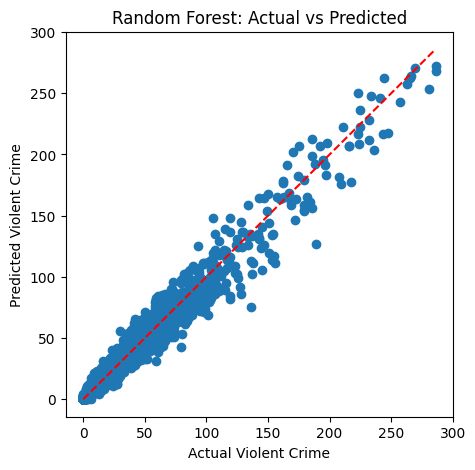

In [70]:
# Plot Predictions vs Actual
rf_preds = rf.predict(X_test)

plt.figure(figsize=(5,5))
plt.scatter(y_test, rf_preds)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color="red", linestyle="--")

plt.xlabel("Actual Violent Crime")
plt.ylabel("Predicted Violent Crime")
plt.title("Random Forest: Actual vs Predicted")
plt.show()

### **Model 2**. XGBoost

In [71]:
# XGBoost
xgb = Pipeline(
    steps=[
        ("preprocessor", tree_preprocessor),
        ("model", XGBRegressor(
            objective="reg:squarederror",
            random_state=42,
            n_jobs=1,
            n_estimators=200,
            learning_rate=0.03,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=5.0,
        )),
    ]
)

xgb.fit(X_train, y_train)

evaluate_model(
    "XGBoost",
    xgb,
    X_train, y_train,
    X_val, y_val,
    X_test, y_test
)


XGBoost
Train MSE: 70.227, RMSE: 8.380
Val MSE: 84.694, RMSE: 9.203
Test MSE: 103.691, RMSE: 10.183


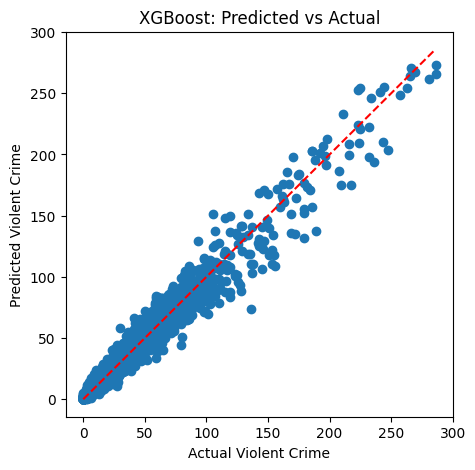

In [72]:
# Plot Predictions vs Actual
xgb_preds = xgb.predict(X_test)

plt.figure(figsize=(5,5))
plt.scatter(y_test, xgb_preds)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color="red", linestyle="--")

plt.xlabel("Actual Violent Crime")
plt.ylabel("Predicted Violent Crime")
plt.title("XGBoost: Predicted vs Actual")
plt.show()